In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
import os
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the path to the original dataset directory
original_dataset_dir = '/kaggle/input/moderate-imbalance-leukemia/Moderate imbalance'

# Define paths for the train and test sets
train_dir = {
    'all': os.path.join(original_dataset_dir, 'Train', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Train', 'hem')
}
test_dir = {
    'all': os.path.join(original_dataset_dir, 'Test', 'all'),
    'hem': os.path.join(original_dataset_dir, 'Test', 'hem')
}

# Define the working directory to copy the dataset
working_dir = '/kaggle/working/imbalance-leukemia/High_imbalance'

# Create the target directories in the working directory if they don't exist
os.makedirs(os.path.join(working_dir, 'Train', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Train', 'hem'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'all'), exist_ok=True)
os.makedirs(os.path.join(working_dir, 'Test', 'hem'), exist_ok=True)

# Copy data from the original dataset to the working directory
try:
    shutil.copytree(train_dir['all'], os.path.join(working_dir, 'Train', 'all'), dirs_exist_ok=True)
    shutil.copytree(train_dir['hem'], os.path.join(working_dir, 'Train', 'hem'), dirs_exist_ok=True)
    shutil.copytree(test_dir['all'], os.path.join(working_dir, 'Test', 'all'), dirs_exist_ok=True)
    shutil.copytree(test_dir['hem'], os.path.join(working_dir, 'Test', 'hem'), dirs_exist_ok=True)
    print("Files copied successfully!")
except Exception as e:
    print(f"Error during copying: {e}")

# Define the LeukemiaDataset class
class LeukemiaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        # Iterate over all subdirectories (all, hem) and get the images
        for label, sub_dir in enumerate(['all', 'hem']):
            class_dir = os.path.join(data_dir, sub_dir)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_files.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.labels[idx]
        
        # Load image and convert to RGB
        image = Image.open(img_path).convert('RGB')
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the paths for the new train and test sets in the working directory
train_dir_working = {
    'all': os.path.join(working_dir, 'Train', 'all'),
    'hem': os.path.join(working_dir, 'Train', 'hem')
}
test_dir_working = {
    'all': os.path.join(working_dir, 'Test', 'all'),
    'hem': os.path.join(working_dir, 'Test', 'hem')
}

# Load train and test datasets from the working directory
train_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Train'), transform=train_transform)
test_dataset = LeukemiaDataset(data_dir=os.path.join(working_dir, 'Test'), transform=val_test_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Function to count the number of files in each directory
def count_files_in_dir(directory):
    file_count = 0
    for sub_dir in ['all', 'hem']:  # Check both 'all' and 'hem' directories
        class_dir = os.path.join(directory, sub_dir)
        if os.path.exists(class_dir):
            file_count += len(os.listdir(class_dir))  # Count files in the sub-directory
    return file_count

# Count files in the training and testing datasets
train_file_count = count_files_in_dir(os.path.join(working_dir, 'Train'))
test_file_count = count_files_in_dir(os.path.join(working_dir, 'Test'))

# Print the counts
print(f"Training set - Total files: {train_file_count}")
print(f"Testing set - Total files: {test_file_count}")


Files copied successfully!
Training set - Total files: 110
Testing set - Total files: 60


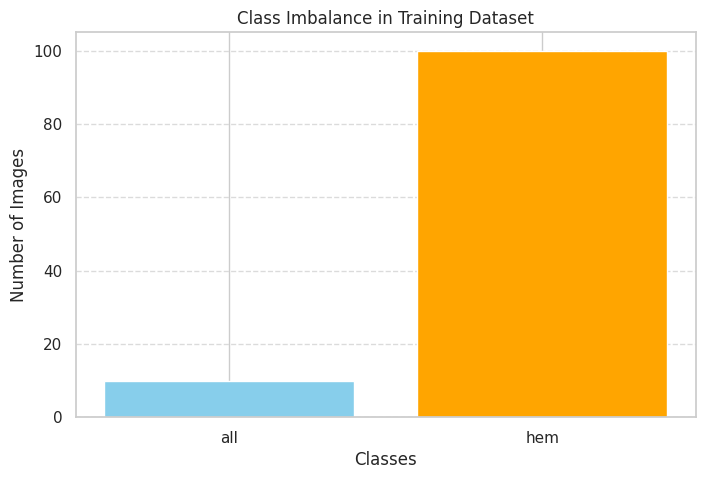

In [3]:
import matplotlib.pyplot as plt

# Function to count the number of images per class
def count_class_distribution(directory):
    class_counts = {}
    for class_name in ['all', 'hem']:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
        else:
            class_counts[class_name] = 0
    return class_counts

# Count class distribution for training set
train_class_counts = count_class_distribution(os.path.join(working_dir, 'Train'))

# Plotting the class distributions for training set
def plot_train_class_distribution(train_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())

    plt.figure(figsize=(8, 5))
    plt.bar(labels, train_values, color=['skyblue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Imbalance in Training Dataset')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot the graph
plot_train_class_distribution(train_class_counts)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import timm

In [5]:
# DIANet Attention Block
class DIABlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(DIABlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        
        # Shared MLP for attention
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Global Average Pooling
        avg_pool = self.global_avg_pool(x).view(batch, channels)
        avg_attention = self.fc(avg_pool).view(batch, channels, 1, 1)
        
        # Global Max Pooling
        max_pool = self.global_max_pool(x).view(batch, channels)
        max_attention = self.fc(max_pool).view(batch, channels, 1, 1)
        
        # Combine both attentions
        combined_attention = avg_attention + max_attention
        return x * combined_attention  # Apply attention weights

In [6]:
class GhostNet_DIAnet(nn.Module):
    def __init__(self, num_classes):
        super(GhostNet_DIAnet, self).__init__()
        # Initialize GhostNet without pre-trained weights
        self.base_model = timm.create_model('ghostnet_100', pretrained=False, num_classes=num_classes)
        self.features = self.base_model.forward_features  # Feature extraction part

        # Add DIABlock after feature extraction
        self.dia_block = DIABlock(in_channels=960, reduction=16)  # 960 is the output channel size of GhostNet's features

        # Global average pooling and classifier
        self.pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Linear(960, num_classes)  # Final classifier

    def forward(self, x):
        # Feature extraction
        features = self.features(x)

        # Apply DIABlock for attention
        attention_features = self.dia_block(features)

        # Global average pooling
        pooled_features = self.pool(attention_features)

        # Flatten and classify
        output = torch.flatten(pooled_features, 1)
        output = self.fc(output)

        return output

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

model = GhostNet_DIAnet(num_classes=num_classes) 

model.to(device)


GhostNet_DIAnet(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (pri

In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
print(model)

GhostNet_DIAnet(
  (base_model): GhostNet(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (pri

In [9]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history


In [14]:
from tqdm import tqdm  # Import tqdm for progress bars

# Train the model
num_epochs = 100
model, history = train_model(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs=num_epochs)


Epoch 1/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Train Loss: 0.1851 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Val Loss: 0.6344 Acc: 0.7000

Epoch 2/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Train Loss: 0.1925 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Val Loss: 0.6437 Acc: 0.6833

Epoch 3/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Train Loss: 0.1953 Acc: 0.9000


Val: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


Val Loss: 0.6800 Acc: 0.6667

Epoch 4/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Train Loss: 0.2066 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Val Loss: 0.6861 Acc: 0.6667

Epoch 5/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Train Loss: 0.1834 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Val Loss: 0.6805 Acc: 0.6667

Epoch 6/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Train Loss: 0.2154 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Val Loss: 0.6488 Acc: 0.6667

Epoch 7/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Train Loss: 0.1707 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Val Loss: 0.6601 Acc: 0.6667

Epoch 8/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Train Loss: 0.1576 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


Val Loss: 0.6120 Acc: 0.7000

Epoch 9/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.2192 Acc: 0.9091


Val: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Val Loss: 0.6035 Acc: 0.7000

Epoch 10/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.1398 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


Val Loss: 0.5987 Acc: 0.7000

Epoch 11/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Train Loss: 0.1859 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Val Loss: 0.6020 Acc: 0.7000

Epoch 12/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Train Loss: 0.1971 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.09it/s]


Val Loss: 0.6091 Acc: 0.7000

Epoch 13/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1645 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]


Val Loss: 0.6238 Acc: 0.7000

Epoch 14/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Train Loss: 0.1932 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Val Loss: 0.6235 Acc: 0.7000

Epoch 15/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Train Loss: 0.1888 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Val Loss: 0.6088 Acc: 0.7000

Epoch 16/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1901 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Val Loss: 0.6158 Acc: 0.7000

Epoch 17/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Train Loss: 0.1793 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Val Loss: 0.6479 Acc: 0.6833

Epoch 18/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1764 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Val Loss: 0.6278 Acc: 0.7000

Epoch 19/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Train Loss: 0.2246 Acc: 0.9091


Val: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Val Loss: 0.6286 Acc: 0.7000

Epoch 20/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.1765 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Val Loss: 0.6085 Acc: 0.7000

Epoch 21/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Train Loss: 0.1424 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Val Loss: 0.5870 Acc: 0.7167

Epoch 22/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.1866 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


Val Loss: 0.5869 Acc: 0.7000

Epoch 23/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]


Train Loss: 0.1699 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Val Loss: 0.5721 Acc: 0.7167

Epoch 24/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Train Loss: 0.1665 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Val Loss: 0.5940 Acc: 0.7000

Epoch 25/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.1652 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s]


Val Loss: 0.6367 Acc: 0.6833

Epoch 26/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Train Loss: 0.1952 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Val Loss: 0.6587 Acc: 0.6667

Epoch 27/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1731 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Val Loss: 0.6501 Acc: 0.6833

Epoch 28/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1770 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.08it/s]


Val Loss: 0.6206 Acc: 0.7000

Epoch 29/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Train Loss: 0.1753 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Val Loss: 0.6234 Acc: 0.7000

Epoch 30/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1912 Acc: 0.9091


Val: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Val Loss: 0.6887 Acc: 0.6667

Epoch 31/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.95it/s]


Train Loss: 0.2238 Acc: 0.9091


Val: 100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Val Loss: 0.6319 Acc: 0.6833

Epoch 32/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Train Loss: 0.1823 Acc: 0.9000


Val: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s]


Val Loss: 0.6370 Acc: 0.6833

Epoch 33/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Train Loss: 0.1356 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Val Loss: 0.6236 Acc: 0.6833

Epoch 34/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Train Loss: 0.2193 Acc: 0.8909


Val: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


Val Loss: 0.5955 Acc: 0.7000

Epoch 35/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Train Loss: 0.2041 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Val Loss: 0.6062 Acc: 0.7000

Epoch 36/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Train Loss: 0.1626 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]


Val Loss: 0.5972 Acc: 0.7167

Epoch 37/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


Train Loss: 0.1674 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Val Loss: 0.6592 Acc: 0.6833

Epoch 38/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Train Loss: 0.1532 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Val Loss: 0.6590 Acc: 0.6667

Epoch 39/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1692 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Val Loss: 0.6868 Acc: 0.6667

Epoch 40/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.03it/s]


Train Loss: 0.1717 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Val Loss: 0.6674 Acc: 0.6667

Epoch 41/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]


Train Loss: 0.2174 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Val Loss: 0.6992 Acc: 0.6667

Epoch 42/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


Train Loss: 0.1805 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


Val Loss: 0.6614 Acc: 0.6667

Epoch 43/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Train Loss: 0.2016 Acc: 0.9091


Val: 100%|██████████| 2/2 [00:00<00:00,  9.04it/s]


Val Loss: 0.6957 Acc: 0.6667

Epoch 44/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


Train Loss: 0.1664 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Val Loss: 0.7110 Acc: 0.6667

Epoch 45/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.2011 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Val Loss: 0.7025 Acc: 0.6667

Epoch 46/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


Train Loss: 0.1910 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Val Loss: 0.6721 Acc: 0.6667

Epoch 47/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Train Loss: 0.1842 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Val Loss: 0.6893 Acc: 0.6667

Epoch 48/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]


Train Loss: 0.1967 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.14it/s]


Val Loss: 0.6887 Acc: 0.6667

Epoch 49/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Train Loss: 0.1581 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


Val Loss: 0.6933 Acc: 0.6667

Epoch 50/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]


Train Loss: 0.1873 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s]


Val Loss: 0.6063 Acc: 0.7000

Epoch 51/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Train Loss: 0.1624 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Val Loss: 0.6342 Acc: 0.7000

Epoch 52/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Train Loss: 0.1578 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Val Loss: 0.6503 Acc: 0.6667

Epoch 53/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.13it/s]


Train Loss: 0.1994 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Val Loss: 0.6764 Acc: 0.6667

Epoch 54/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Train Loss: 0.1906 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Val Loss: 0.6132 Acc: 0.7000

Epoch 55/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


Train Loss: 0.1763 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Val Loss: 0.6280 Acc: 0.7000

Epoch 56/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1720 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]


Val Loss: 0.6382 Acc: 0.6833

Epoch 57/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


Train Loss: 0.1760 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]


Val Loss: 0.6123 Acc: 0.7000

Epoch 58/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Train Loss: 0.1728 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Val Loss: 0.6137 Acc: 0.7000

Epoch 59/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1774 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]


Val Loss: 0.6167 Acc: 0.7000

Epoch 60/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.2239 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


Val Loss: 0.6191 Acc: 0.7000

Epoch 61/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Train Loss: 0.1970 Acc: 0.9091


Val: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s]


Val Loss: 0.5949 Acc: 0.7000

Epoch 62/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.1770 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Val Loss: 0.5820 Acc: 0.7000

Epoch 63/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1628 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


Val Loss: 0.5706 Acc: 0.7333

Epoch 64/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Train Loss: 0.2001 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]


Val Loss: 0.5658 Acc: 0.7333

Epoch 65/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Train Loss: 0.1747 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Val Loss: 0.5756 Acc: 0.7167

Epoch 66/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


Train Loss: 0.1843 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


Val Loss: 0.5960 Acc: 0.7000

Epoch 67/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.2194 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


Val Loss: 0.6208 Acc: 0.7000

Epoch 68/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.1897 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Val Loss: 0.6866 Acc: 0.6667

Epoch 69/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


Train Loss: 0.1881 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Val Loss: 0.6638 Acc: 0.6667

Epoch 70/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Train Loss: 0.2054 Acc: 0.8909


Val: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Val Loss: 0.6757 Acc: 0.6667

Epoch 71/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.1676 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


Val Loss: 0.6589 Acc: 0.6667

Epoch 72/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Train Loss: 0.1974 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


Val Loss: 0.6382 Acc: 0.6833

Epoch 73/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Train Loss: 0.1620 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]


Val Loss: 0.6630 Acc: 0.6667

Epoch 74/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Train Loss: 0.1748 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Val Loss: 0.6623 Acc: 0.6667

Epoch 75/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


Train Loss: 0.2043 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.25it/s]


Val Loss: 0.6867 Acc: 0.6667

Epoch 76/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]


Train Loss: 0.1597 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Val Loss: 0.6399 Acc: 0.6833

Epoch 77/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.96it/s]


Train Loss: 0.2089 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Val Loss: 0.6962 Acc: 0.6667

Epoch 78/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Train Loss: 0.2265 Acc: 0.8909


Val: 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]


Val Loss: 0.6549 Acc: 0.6667

Epoch 79/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]


Train Loss: 0.1815 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]


Val Loss: 0.6273 Acc: 0.7000

Epoch 80/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


Train Loss: 0.1797 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Val Loss: 0.6548 Acc: 0.6833

Epoch 81/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1567 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]


Val Loss: 0.6419 Acc: 0.6833

Epoch 82/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.1960 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]


Val Loss: 0.6296 Acc: 0.6833

Epoch 83/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]


Train Loss: 0.1787 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Val Loss: 0.6230 Acc: 0.7000

Epoch 84/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1797 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]


Val Loss: 0.6591 Acc: 0.6667

Epoch 85/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Train Loss: 0.1790 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


Val Loss: 0.6790 Acc: 0.6667

Epoch 86/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1819 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Val Loss: 0.6571 Acc: 0.6833

Epoch 87/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


Train Loss: 0.1505 Acc: 0.9545


Val: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Val Loss: 0.6499 Acc: 0.6833

Epoch 88/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Train Loss: 0.2096 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.05it/s]


Val Loss: 0.6609 Acc: 0.6667

Epoch 89/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Train Loss: 0.1833 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Val Loss: 0.6726 Acc: 0.6667

Epoch 90/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]


Train Loss: 0.1796 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]


Val Loss: 0.6391 Acc: 0.6833

Epoch 91/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]


Train Loss: 0.1955 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Val Loss: 0.6361 Acc: 0.6833

Epoch 92/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]


Train Loss: 0.1973 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.24it/s]


Val Loss: 0.6668 Acc: 0.6667

Epoch 93/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


Train Loss: 0.1806 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]


Val Loss: 0.6266 Acc: 0.7000

Epoch 94/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


Train Loss: 0.1757 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


Val Loss: 0.6430 Acc: 0.6833

Epoch 95/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Train Loss: 0.1807 Acc: 0.9455


Val: 100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


Val Loss: 0.6618 Acc: 0.6667

Epoch 96/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Train Loss: 0.1540 Acc: 0.9273


Val: 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Val Loss: 0.6774 Acc: 0.6667

Epoch 97/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


Train Loss: 0.1798 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


Val Loss: 0.6794 Acc: 0.6667

Epoch 98/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


Train Loss: 0.1626 Acc: 0.9182


Val: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s]


Val Loss: 0.6679 Acc: 0.6667

Epoch 99/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.1798 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Val Loss: 0.6343 Acc: 0.6833

Epoch 100/100
----------


Train: 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


Train Loss: 0.1859 Acc: 0.9364


Val: 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

Val Loss: 0.6156 Acc: 0.7000

Best Validation Acc: 0.7333


Testing: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]


Classification Report:
              precision    recall  f1-score   support

         All       1.00      0.40      0.57        30
         Hem       0.62      1.00      0.77        30

    accuracy                           0.70        60
   macro avg       0.81      0.70      0.67        60
weighted avg       0.81      0.70      0.67        60



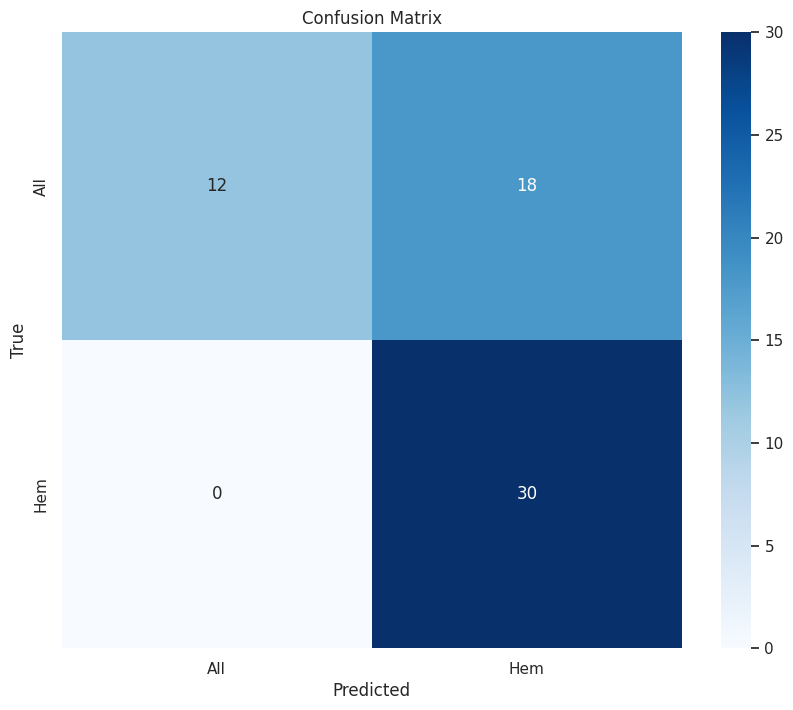

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model on the test set
evaluate_model(model, test_loader, classes=['All', 'Hem'])

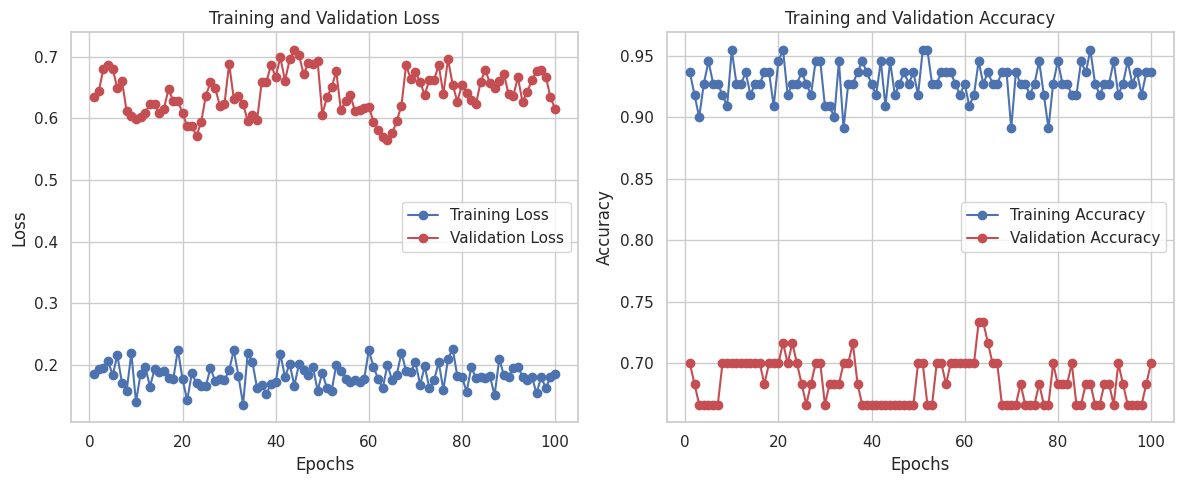

In [16]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)


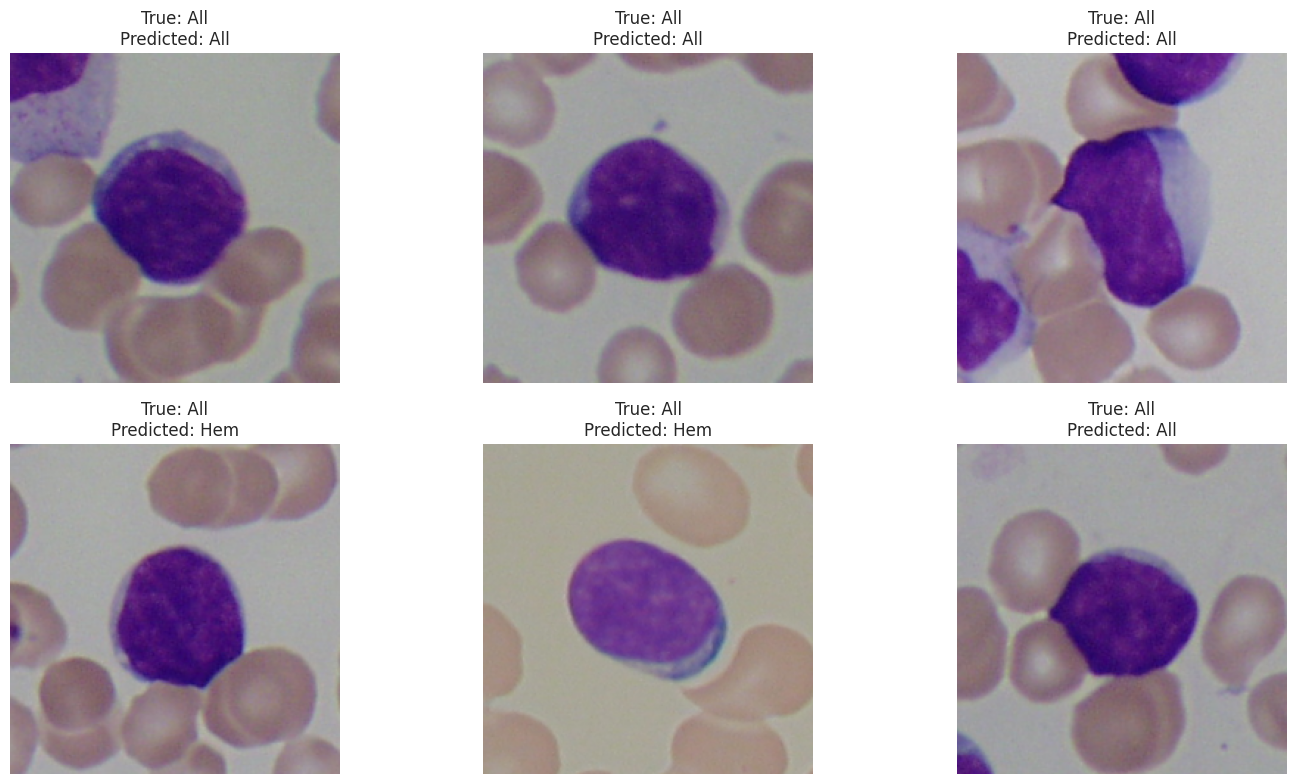

In [17]:
import numpy as np
def visualize_predictions(model, dataloader, classes, num_images=6):
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample predictions
visualize_predictions(model, test_loader, classes=['All', 'Hem'], num_images=6)
